# Passing By Barca Manager

In [4]:
from statsbombpy import sb
import sbutilities as sbut
import soccerplotly as socly

import pandas as pd
import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from scipy.cluster.vq import whiten, vq, kmeans
from numpy import random
from datetime import datetime


---
## Get all Barca Match Ids

In [105]:
all_comps = sb.competitions()
laliga_comp_id = 11
#----
df_laliga_season = all_comps[all_comps['competition_id']==laliga_comp_id]
#----
dfs_barca_matches = []
for sid in df_laliga_season['season_id']:
    dfs_barca_matches.append(sb.matches(competition_id=laliga_comp_id, season_id=sid))

df_barca_matches = pd.concat(dfs_barca_matches)


credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only


In [106]:
df_barca_matches.to_pickle('df_all_barca_matches.pkl')

---
## Get Lineups for each Match Id

In [79]:
df_all_barca_matches = pd.read_pickle('df_all_barca_matches.pkl')

In [45]:
sb.events(match_id=temp_id, split=True, flatten_attrs=True).keys()

credentials were not supplied. open data access only


dict_keys(['starting_xis', 'half_starts', 'passes', 'ball_receipts', 'carrys', 'pressures', 'dribbled_pasts', 'dribbles', 'duels', 'ball_recoverys', 'dispossesseds', 'shots', 'goal_keepers', 'blocks', 'clearances', 'interceptions', 'foul_committeds', 'foul_wons', 'miscontrols', 'half_ends', 'substitutions', 'injury_stoppages', 'tactical_shifts'])

---
## DataFrame of Manager and Matches 


In [8]:
df_managers = pd.DataFrame([[None, None, None, None, None, None]])
df_managers.columns=['match_id','season_id','season_name', 'barcelona_manager', 'opposing_manager', 'opposing_team']
df_managers

,match_id,season_id,season_name,barcelona_manager,opposing_manager,opposing_team
0,None,None,None,None,None,None


In [74]:
# Manager DataFrame

manager_tenures = [['Ronald Koeman', 'Aug 19, 2020', 'Oct 28, 2021'],
['Quique Setién', 'Jan 13, 2020', 'Aug 17, 2020'],
['Ernesto Valverde', 'Jul 1, 2017', 'Jan 13, 2020'],
['Luis Enrique', 'Jul 1, 2014', 'Jun 30, 2017'], 
['Tata Martino', 'Jul 26, 2013', 'Jun 30, 2014'],
['Tito Vilanova', 'Apr 1, 2013', 'Jul 19, 2013'],
['Jordi Roura', 'Jan 24, 2013', 'Mar 31, 2013'],
['Tito Vilanova', 'Jul 1, 2012', 'Jan 23, 2013'],
['Pep Guardiola', 'Jul 1, 2008','Jun 30, 2012'], 
['Frank Rijkaard', 'Jul 1, 2003', 'Jun 30, 2008'],
]

df_manager_tenures = pd.DataFrame(manager_tenures)
df_manager_tenures.columns = ['manager_name', 'start_date', 'end_date']

def conv_mgr_date(date_str):
    return datetime.strptime(date_str, "%b %d, %Y")

df_manager_tenures['start_date'] = df_manager_tenures['start_date'].apply(conv_mgr_date)
df_manager_tenures['end_date'] = df_manager_tenures['end_date'].apply(conv_mgr_date)

df_manager_tenures.to_pickle('df_barca_manager_tenures.pkl')

,manager_name,start_date,end_date
0,Ronald Koeman,"Aug 19, 2020","Oct 28, 2021"
1,Quique Setién,"Jan 13, 2020","Aug 17, 2020"
2,Ernesto Valverde,"Jul 1, 2017","Jan 13, 2020"
3,Luis Enrique,"Jul 1, 2014","Jun 30, 2017"
4,Tata Martino,"Jul 26, 2013","Jun 30, 2014"
5,Tito Vilanova,"Apr 1, 2013","Jul 19, 2013"
6,Jordi Roura,"Jan 24, 2013","Mar 31, 2013"
7,Tito Vilanova,"Jul 1, 2012","Jan 23, 2013"
8,Pep Guardiola,"Jul 1, 2008","Jun 30, 2012"
9,Frank Rijkaard,"Jul 1, 2003","Jun 30, 2008"


In [78]:
df_manager_tenures = pd.read_pickle('df_barca_manager_tenures.pkl')
df_manager_tenures

,manager_name,start_date,end_date
0,Ronald Koeman,2020-08-19,2021-10-28
1,Quique Setién,2020-01-13,2020-08-17
2,Ernesto Valverde,2017-07-01,2020-01-13
3,Luis Enrique,2014-07-01,2017-06-30
4,Tata Martino,2013-07-26,2014-06-30
5,Tito Vilanova,2013-04-01,2013-07-19
6,Jordi Roura,2013-01-24,2013-03-31
7,Tito Vilanova,2012-07-01,2013-01-23
8,Pep Guardiola,2008-07-01,2012-06-30
9,Frank Rijkaard,2003-07-01,2008-06-30


---
## Join Manager column to matches

In [123]:
df_all_barca_matches = pd.read_pickle('df_all_barca_matches.pkl')
df_manager_tenures = pd.read_pickle('df_barca_manager_tenures.pkl')

In [124]:
# add barca manager to mathes df according to manager active dates

def find_active_manager(date_value):
    date_value = datetime.strptime(date_value, "%Y-%m-%d")
    
    for mgr_row in df_manager_tenures.itertuples():
        if (getattr(mgr_row,'start_date') <=  date_value) and (date_value < getattr(mgr_row,'end_date')): 
            return getattr(mgr_row,'manager_name')

df_all_barca_matches['barca_manager'] = df_all_barca_matches['match_date'].apply(find_active_manager)

df_all_barca_matches = df_all_barca_matches.sort_values('match_date').reset_index(drop=True)
df_all_barca_matches.to_pickle('df_all_barca_matches_wmgr.pkl')

In [125]:
df_all_barca_matches_wmgr = pd.read_pickle('df_all_barca_matches_wmgr.pkl')
df_all_barca_matches_wmgr 
#df_all_barca_matches_wmgr[['match_date', 'home_team', 'away_team', 'barca_manager']].sort_values('match_date')

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated,last_updated_360,match_week,competition_stage,stadium,referee,data_version,shot_fidelity_version,xy_fidelity_version,barca_manager
0,68353,2004-10-16,22:00:00.000,Spain - La Liga,2004/2005,Espanyol,Barcelona,0,1,available,...,2020-07-29T05:00,2021-06-13T16:17:31.694,7,Regular Season,Estadi Olímpic Lluís Companys,Carlos Megía Dávila,1.1.0,2,2,Frank Rijkaard
1,68313,2004-10-24,21:00:00.000,Spain - La Liga,2004/2005,Barcelona,Osasuna,3,0,available,...,2020-07-29T05:00,2021-06-13T16:17:31.694,8,Regular Season,Camp Nou,Vicente José Lizondo Cortés,1.1.0,2,2,Frank Rijkaard
2,68314,2004-12-04,20:00:00.000,Spain - La Liga,2004/2005,Barcelona,Málaga,4,0,available,...,2020-07-29T05:00,2021-06-13T16:17:31.694,14,Regular Season,Camp Nou,José Omar Losantos,1.1.0,2,2,Frank Rijkaard
3,69153,2004-12-11,20:00:00.000,Spain - La Liga,2004/2005,Albacete,Barcelona,1,2,available,...,2020-07-29T05:00,2021-06-13T16:17:31.694,15,Regular Season,Estadio Carlos Belmonte,Alfonso Perez Burrull,1.1.0,2,2,Frank Rijkaard
4,68315,2004-12-21,20:00:00.000,Spain - La Liga,2004/2005,Barcelona,Levante,2,1,available,...,2020-07-29T05:00,2021-06-13T16:17:31.694,17,Regular Season,Camp Nou,David Fernández Borbalan,1.1.0,2,2,Frank Rijkaard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,3773586,2021-04-29,19:00:00.000,Spain - La Liga,2020/2021,Barcelona,Granada,1,2,available,...,2021-07-06T16:43:21.218,2021-07-27T01:19:41.897076,33,Regular Season,Camp Nou,Pablo González Fuertes,1.1.0,2,2,Ronald Koeman
516,3773695,2021-05-02,21:00:00.000,Spain - La Liga,2020/2021,Valencia,Barcelona,2,3,available,...,2021-05-07T13:24:24.423335,2021-07-27T01:18:50.218008,34,Regular Season,Estadio de Mestalla,José María Sánchez Martínez,1.1.0,2,2,Ronald Koeman
517,3773372,2021-05-08,16:15:00.000,Spain - La Liga,2020/2021,Barcelona,Atlético Madrid,0,0,available,...,2021-05-10T04:24:10.396826,2021-07-27T01:16:38.082497,35,Regular Season,Camp Nou,Antonio Miguel Mateu Lahoz,1.1.0,2,2,Ronald Koeman
518,3773387,2021-05-11,22:00:00.000,Spain - La Liga,2020/2021,Levante,Barcelona,3,3,available,...,2021-05-13T00:20:44.739341,2021-07-27T01:16:02.992919,36,Regular Season,Estadio Ciudad de Valencia,José Luis Munuera Montero,1.1.0,2,2,Ronald Koeman


---
## all barca match_ids -> get passes to shots -> get shot xG

In [10]:
df_shot_assists = pd.DataFrame([[None, None, None, None]])
df_shot_assists.columns=['match_id','passing_..._columns', 'shot_xg', 'other_shot_columns']
df_shot_assists

,match_id,passing_..._columns,shot_xg,other_shot_columns
0,None,None,None,None


In [46]:
def get_passes_to_shots(df, team=None, split=True):
    """
    df - pandas dataframe produced by sb.events(<matchid>, split=True)
    team - str (optional. default: None) : Name of team 
    split - bool (optional. default: True) : is incoming data of sb format "split=True"
    """
    if not split: 
        
        print('not implemented')
    else:
        df_passes = df['passes']
        df_shots = df['shots']
    
    if team:
        df_passes = df_passes[df_passes['possession_team']==team]
    
    pass_to_shot_mask = df_passes['pass_shot_assist']==True
    df_shot_assists = df_passes[pass_to_shot_mask]
    
    df_shot_assists = sbut.expand_sb_location_col(df_shot_assists)
    df_shot_assists = sbut.expand_sb_location_col(df_shot_assists, 'pass_end_location')
    
    df_shots = df_shots[['shot_statsbomb_xg','id']]
    df_shot_assists = df_shot_assists.join(df_shots.set_index('id'), on='pass_assisted_shot_id')
    
    return df_shot_assists

In [150]:
df_all_barca_matches['match_id'].tolist()

[68353,
 68313,
 68314,
 69153,
 68315,
 68352,
 68316,
 68317,
 68318,
 69164,
 68339,
 68319,
 68354,
 68320,
 68321,
 68322,
 68323,
 68348,
 68342,
 68324,
 68325,
 68350,
 69172,
 68351,
 68326,
 68327,
 68340,
 68328,
 68347,
 68329,
 68330,
 69174,
 68331,
 69154,
 68332,
 68333,
 68334,
 68335,
 68341,
 69175,
 69179,
 69159,
 69155,
 69156,
 69160,
 69162,
 69176,
 69157,
 69165,
 68336,
 69180,
 69169,
 69148,
 69143,
 69151,
 69144,
 68364,
 69158,
 68363,
 69166,
 69178,
 69184,
 68356,
 69170,
 69145,
 69173,
 69181,
 69187,
 69146,
 69182,
 68360,
 68365,
 68358,
 68359,
 69141,
 68361,
 68366,
 69186,
 69147,
 69215,
 69138,
 69207,
 69211,
 69212,
 69232,
 69235,
 69279,
 69285,
 69171,
 69149,
 69225,
 69228,
 69230,
 69183,
 69189,
 69209,
 69231,
 69195,
 69139,
 69185,
 69216,
 69177,
 69142,
 69273,
 69222,
 69223,
 69251,
 69249,
 69217,
 69229,
 69292,
 69254,
 69255,
 69256,
 69252,
 69253,
 69277,
 69250,
 69288,
 69262,
 69267,
 69218,
 69219,
 69243,
 69210,


In [153]:
dfs_ps2shot = []
for mid in df_all_barca_matches['match_id'].tolist():
    df_mid = sb.events(match_id=mid, split=True, flatten_attrs=True)
    dfs_ps2shot.append(get_passes_to_shots(df_mid))

df_all_barca_ps2shot = pd.concat(dfs_ps2shot)
df_all_barca_ps2shot.to_pickle('df_all_barca_ps2shot.pkl')

credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data acces

credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data acces

credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data acces

credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data acces

In [186]:
pd.read_pickle('df_all_barca_ps2shot.pkl').columns

Index(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'type',
       'possession', 'possession_team', 'play_pattern', 'team', 'player',
       'position', 'location', 'duration', 'related_events', 'match_id',
       'pass_recipient', 'pass_length', 'pass_angle', 'pass_height',
       'pass_end_location', 'pass_body_part', 'pass_type', 'under_pressure',
       'pass_outcome', 'pass_switch', 'off_camera', 'pass_cross',
       'pass_aerial_won', 'pass_assisted_shot_id', 'pass_shot_assist',
       'pass_goal_assist', 'pass_outswinging', 'pass_technique',
       'pass_inswinging', 'pass_straight', 'out', 'pass_through_ball',
       'pass_no_touch', 'pass_cut_back', 'loc_x', 'loc_y_raw', 'loc_y',
       'pass_end_location_loc_x', 'pass_end_location_loc_y_raw',
       'pass_end_location_loc_y', 'shot_statsbomb_xg', 'pass_deflected',
       'counterpress', 'pass_miscommunication', 'pass_backheel'],
      dtype='object')

---
## Join df_Managers with df_shot_assists 
(or some other filtering method like match_id is in list of manager matches etc.)

In [160]:
df_ps2shot = pd.read_pickle('df_all_barca_ps2shot.pkl')
df_match_mgr = pd.read_pickle('df_all_barca_matches_wmgr.pkl')

In [159]:
# verify match_id error fixed
df_ps2shot['match_id'].unique().tolist() == df_all_barca_matches['match_id'].tolist()

True

In [163]:
df_p2s_f = df_ps2shot.join(df_match_mgr.set_index('match_id'), on='match_id')

df_p2s_f.to_pickle('df_barca_p2s_final.pkl')

In [166]:
df_p2s_f[['match_date','match_id', 'barca_manager','loc_x', 'loc_y', 'pass_end_location_loc_x', 'pass_end_location_loc_y', 'shot_statsbomb_xg']].sort_values('match_date')

,match_date,match_id,barca_manager,loc_x,loc_y,pass_end_location_loc_x,pass_end_location_loc_y,shot_statsbomb_xg
62,2004-10-16,68353,Frank Rijkaard,86.4,13.5,95.3,34.5,0.060501
741,2004-10-16,68353,Frank Rijkaard,106.8,10.5,109.3,34.7,0.051609
714,2004-10-16,68353,Frank Rijkaard,116.7,53.8,108.7,45.4,0.113389
644,2004-10-16,68353,Frank Rijkaard,95.0,12.8,88.1,26.0,0.016882
599,2004-10-16,68353,Frank Rijkaard,82.9,46.4,104.3,57.6,0.192773
...,...,...,...,...,...,...,...,...
142,2021-05-16,3773457,Ronald Koeman,109.9,12.8,99.3,41.1,0.082980
105,2021-05-16,3773457,Ronald Koeman,108.8,59.8,96.3,37.0,0.037436
1196,2021-05-16,3773457,Ronald Koeman,64.9,23.4,89.1,7.7,0.017459
862,2021-05-16,3773457,Ronald Koeman,95.7,53.3,97.7,24.7,0.027692


---
## Go Through Each Manager and Cluster Passes-to-Shots 
#### (including xg threshold input option)

In [168]:
# Manager Options
manager_opts = pd.read_pickle('df_barca_manager_tenures.pkl')
manager_opts

,manager_name,start_date,end_date
0,Ronald Koeman,2020-08-19,2021-10-28
1,Quique Setién,2020-01-13,2020-08-17
2,Ernesto Valverde,2017-07-01,2020-01-13
3,Luis Enrique,2014-07-01,2017-06-30
4,Tata Martino,2013-07-26,2014-06-30
5,Tito Vilanova,2013-04-01,2013-07-19
6,Jordi Roura,2013-01-24,2013-03-31
7,Tito Vilanova,2012-07-01,2013-01-23
8,Pep Guardiola,2008-07-01,2012-06-30
9,Frank Rijkaard,2003-07-01,2008-06-30


In [173]:
selected_manager = 'Luis Enrique'
all_p2s = pd.read_pickle('df_barca_p2s_final.pkl')
collected_passes = all_p2s[all_p2s['barca_manager']==selected_manager]
collected_passes.columns

Index(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'type',
       'possession', 'possession_team', 'play_pattern', 'team', 'player',
       'position', 'location', 'duration', 'related_events', 'match_id',
       'pass_recipient', 'pass_length', 'pass_angle', 'pass_height',
       'pass_end_location', 'pass_body_part', 'pass_type', 'under_pressure',
       'pass_outcome', 'pass_switch', 'off_camera', 'pass_cross',
       'pass_aerial_won', 'pass_assisted_shot_id', 'pass_shot_assist',
       'pass_goal_assist', 'pass_outswinging', 'pass_technique',
       'pass_inswinging', 'pass_straight', 'out', 'pass_through_ball',
       'pass_no_touch', 'pass_cut_back', 'loc_x', 'loc_y_raw', 'loc_y',
       'pass_end_location_loc_x', 'pass_end_location_loc_y_raw',
       'pass_end_location_loc_y', 'shot_statsbomb_xg', 'pass_deflected',
       'counterpress', 'pass_miscommunication', 'pass_backheel', 'match_date',
       'kick_off', 'competition', 'season', 'home_team', 'away_team',
  

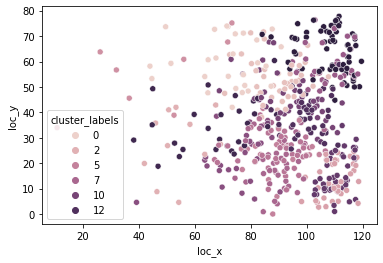

,freq,freq_pct
cluster_labels,,
14,64,0.126
10,48,0.095
11,44,0.087
1,42,0.083
6,42,0.083
7,40,0.079
3,39,0.077
12,37,0.073
8,32,0.063


In [193]:
#-------------------
# perform and display clustering analysis
#-------------------

# Simulate User input
#----
selected_manager = 'Frank Rijkaard'
selected_xg_min = 0.05
#----

# load all assists to shots
all_p2s = pd.read_pickle('df_barca_p2s_final.pkl')

# apply maks for selected manager and minimum xg required
manager_mask = all_p2s['barca_manager']==selected_manager
xg_mask = all_p2s['shot_statsbomb_xg']>selected_xg_min
non_corner_mask = all_p2s['pass_type']!='Corner'

final_mask = manager_mask & xg_mask & non_corner_mask
df = all_p2s[final_mask]

#---
# which features to include
p2s_cluster_feats = ['loc_x', 'loc_y', 'pass_end_location_loc_x',
                     'pass_end_location_loc_y', 'pass_angle']

feat_options = ['loc_x', 'loc_y', 'pass_end_location_loc_x',
                'pass_end_location_loc_y', 'pass_angle','pass_height', 'pass_length',  'shot_statsbomb_xg']
#---
df = df[p2s_cluster_feats]

# standardized 
df_w = pd.DataFrame(whiten(df))

# number of clusters to use
num_clusters = 15

# perform clustering and labeling
random.seed(0)
cluster_centers, distortion = kmeans(df_w, num_clusters)
df['cluster_labels'], distortion_list = vq(df_w, cluster_centers)

# scatter plot with cluster colors
sns.scatterplot(x='loc_x', y='loc_y', data=df, hue='cluster_labels')
plt.show()

# calculate frequency of occurrence for clusters
cl_freq = df.groupby('cluster_labels').count()[['loc_x']].sort_values(by='loc_x', ascending=False)
cl_freq.columns = ['freq']
cl_freq['freq_pct'] = round(cl_freq['freq']/cl_freq['freq'].sum(),3)

# make plot for each cluster of passes
cluster_pct = cl_freq['freq_pct'].tolist()
cluster_num = cl_freq.index.tolist()
display(cl_freq)

for i, cl in enumerate(cluster_num):
    df_cl = df[df['cluster_labels']==cl]
    
    fig = socly.plot_passes(df_cl, title=f"cluster {cl} - pct: {round(100*cluster_pct[i],1)}", show_outcome=False)
    fig.show()

In [194]:
#------
# Vizualizing Cluster Centers
#------

df_std = df[p2s_cluster_feats].std()

de_whitened_centers = np.multiply(cluster_centers,df_std.to_numpy())
df_centers = pd.DataFrame(de_whitened_centers)
df_centers.columns = p2s_cluster_feats
#--
df_centers = df_centers.join(cl_freq)
#--


# fig = px.scatter(df_centers, x='loc_x', y='loc_y', color='freq_pct', color_continuous_scale=["white", "red"])
# fig = socly.draw_pitch_lines(fig)
# fig.show()
fig = socly.plot_pass_clusters(df_centers, title=f"Cluster Centers - {num_clusters}", show_outcome=False)
fig.show()
# ---
display(df_centers)

,loc_x,loc_y,pass_end_location_loc_x,pass_end_location_loc_y,pass_angle,freq,freq_pct
0,72.360683,59.758963,92.358986,44.615450,0.789422,28,0.055
1,90.184221,53.102395,108.514212,52.814015,-0.014233,42,0.083
2,54.754025,28.045854,74.955776,18.236175,0.438622,11,0.022
3,110.393538,13.361902,112.739443,43.309399,-1.501366,39,0.077
4,44.969370,55.404667,64.939074,62.774438,-0.617162,8,0.016
5,89.653459,23.563249,89.643449,34.989523,-1.733523,20,0.039
6,89.681344,24.638596,109.400801,26.130544,-0.105473,42,0.083
7,89.595902,20.850573,109.498040,41.578525,-0.769315,40,0.079
8,108.572752,58.607827,104.396756,46.229989,1.960995,32,0.063
9,75.470465,21.997705,93.864614,23.026720,0.181648,25,0.049


In [ ]:
### Functions for sbut

In [206]:

def make_barca_manager_clusters(selected_manager, selected_xg_min):
    """
    selected_manager : str
    selected_xg_min : float
    """
    # load all assists to shots
    all_p2s = pd.read_pickle('df_barca_p2s_final.pkl')

    # apply maks for selected manager and minimum xg required
    manager_mask = all_p2s['barca_manager']==selected_manager
    xg_mask = all_p2s['shot_statsbomb_xg']>selected_xg_min
    non_corner_mask = all_p2s['pass_type']!='Corner'

    final_mask = manager_mask & xg_mask & non_corner_mask
    df = all_p2s[final_mask]

    #---
    # which features to include
    p2s_cluster_feats = ['loc_x', 'loc_y', 'pass_end_location_loc_x',
                         'pass_end_location_loc_y', 'pass_angle']

    feat_options = ['loc_x', 'loc_y', 'pass_end_location_loc_x',
                    'pass_end_location_loc_y', 'pass_angle','pass_height', 'pass_length',  'shot_statsbomb_xg']
    #---
    df = df[p2s_cluster_feats]

    # standardized 
    df_w = pd.DataFrame(whiten(df))

    # number of clusters to use
    num_clusters = 15

    # perform clustering and labeling
    random.seed(0)
    cluster_centers, distortion = kmeans(df_w, num_clusters)
    df['cluster_labels'], distortion_list = vq(df_w, cluster_centers)

    # scatter plot with cluster colors
    px.scatter(df, x='loc_x', y='loc_y', color='cluster_labels')

    # calculate frequency of occurrence for clusters
    cl_freq = df.groupby('cluster_labels').count()[['loc_x']].sort_values(by='loc_x', ascending=False)
    cl_freq.columns = ['freq']
    cl_freq['freq_pct'] = round(cl_freq['freq']/cl_freq['freq'].sum(),3)

    # make plot for each cluster of passes
    cluster_pct = cl_freq['freq_pct'].tolist()
    cluster_num = cl_freq.index.tolist()
    #display(cl_freq)
    
    cl_figs = []
    for i, cl in enumerate(cluster_num):
        df_cl = df[df['cluster_labels']==cl]

        fig = socly.plot_passes(df_cl, title=f"cluster {cl} - pct: {round(100*cluster_pct[i],1)}", show_outcome=False)
        #fig.show()
        cl_figs.append(fig)
        
    #----------
    # Vizualizing Cluster Centers
    #----------

    df_std = df[p2s_cluster_feats].std()

    de_whitened_centers = np.multiply(cluster_centers,df_std.to_numpy())
    df_centers = pd.DataFrame(de_whitened_centers)
    df_centers.columns = p2s_cluster_feats
    #--
    df_centers = df_centers.join(cl_freq)
    #--
    center_fig = socly.plot_pass_clusters(df_centers, title=f"Cluster Centers - {num_clusters}", show_outcome=False)
    # ---

    return cl_freq, cl_figs, center_fig, df_centers

In [5]:
selected_manager = 'Frank Rijkaard'
selected_xg_min = 0.05

df_freq, cl_figs, center_fig, df_centers = sbut.make_barca_manager_clusters(selected_manager, selected_xg_min)

,loc_x,loc_y,pass_end_location_loc_x,pass_end_location_loc_y,pass_angle,freq,freq_pct
0,72.360683,59.758963,92.358986,44.615450,0.789422,28,0.055
1,90.184221,53.102395,108.514212,52.814015,-0.014233,42,0.083
2,54.754025,28.045854,74.955776,18.236175,0.438622,11,0.022
3,110.393538,13.361902,112.739443,43.309399,-1.501366,39,0.077
4,44.969370,55.404667,64.939074,62.774438,-0.617162,8,0.016
5,89.653459,23.563249,89.643449,34.989523,-1.733523,20,0.039
6,89.681344,24.638596,109.400801,26.130544,-0.105473,42,0.083
7,89.595902,20.850573,109.498040,41.578525,-0.769315,40,0.079
8,108.572752,58.607827,104.396756,46.229989,1.960995,32,0.063
9,75.470465,21.997705,93.864614,23.026720,0.181648,25,0.049
